# Grocery Market Basket Analysis - Sequential Pattern Mining

**Team:** mazen moharm , hady mohamed , mohamed mosbah  
**Assignment:** Sequential Pattern Mining :)  
**Date:** 12/11/2025

---

## Introduction

This notebook demonstrates **Sequential Pattern Mining** on a grocery retail dataset. The goal is to discover **frequent purchase sequences** among customers, which can help in understanding buying behavior, product recommendations, and market basket analysis.

We will perform the following steps:

1. **Data Preprocessing:** Cleaning and preparing the dataset by keeping only relevant columns (`CustomerID`, `Date`, `Item`) and creating sequences of items purchased per customer.  
2. **Sequential Pattern Mining Algorithms:** Apply **GSP (Generalized Sequential Pattern)** and **PrefixSpan** to extract frequent sequential patterns.  
3. **Analysis and Visualization:** Display the top frequent sequences, compare the algorithms in terms of runtime and discovered patterns, and visualize the results.  

The dataset used in this notebook contains ~39,000 grocery purchase records with customer IDs, purchase dates, and item descriptions.


In [ ]:
#Import 
import pandas as pd
import numpy as np
import pickle
import time
from prefixspan import PrefixSpan
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [23]:
#Data Loading and Initial Exploration
def load_and_explore_data():
    """Load the dataset and perform initial exploration"""
    print("📊 LOADING AND EXPLORING GROCERIES DATASET")
    print("=" * 50)
    
    # Load data
    df = pd.read_csv("../data/Groceries_dataset.csv")
    
    # Basic information
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Number of Unique Customers: {df['Member_number'].nunique()}")
    print(f"Number of Unique Products: {df['itemDescription'].nunique()}")
    
    # Display sample data
    print("\nSample Data (First 10 rows):")
    display(df.head(10))
    
    return df

df = load_and_explore_data()

📊 LOADING AND EXPLORING GROCERIES DATASET
Dataset Shape: (38765, 3)
Columns: ['Member_number', 'Date', 'itemDescription']
Date Range: 01-01-2014 to 31-10-2015
Number of Unique Customers: 3898
Number of Unique Products: 167

Sample Data (First 10 rows):


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
5,4941,14-02-2015,rolls/buns
6,4501,08-05-2015,other vegetables
7,3803,23-12-2015,pot plants
8,2762,20-03-2015,whole milk
9,4119,12-02-2015,tropical fruit


In [24]:
df.rename(columns={
    'Member_number': 'CustomerID',
    'itemDescription': 'Item'
}, inplace=True)

df['CustomerID'] = df['CustomerID'].astype(str)

df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

df = df.sort_values(by=['CustomerID', 'Date'])


customer_sequences = df.groupby('CustomerID')['Item'].apply(list)


example_customer = customer_sequences.index[0]
print("Customer ID:", example_customer)
print("Sequence length:", len(customer_sequences.loc[example_customer]))
print(customer_sequences.loc[example_customer][:20])


transactions = customer_sequences.tolist()
with open("../data/transactions.pkl", "wb") as f:
    pickle.dump(transactions, f)

print("✅ Prepared", len(transactions), "sequences (one per customer). Saved to '../data/transactions.pkl'")

Customer ID: 1000
Sequence length: 13
['whole milk', 'pastry', 'salty snack', 'sausage', 'whole milk', 'semi-finished bread', 'yogurt', 'soda', 'pickled vegetables', 'canned beer', 'misc. beverages', 'sausage', 'hygiene articles']
✅ Prepared 3898 sequences (one per customer). Saved to '../data/transactions.pkl'


## Data Preprocessing and Sequence Creation

In [26]:

def preprocess_data(df):
    """Clean and prepare data for sequential pattern mining"""
    print(" PREPROCESSING DATA")
    print("=" * 50)
    
    # Create a copy and rename columns
    processed_df = df.copy()
    processed_df.rename(columns={
        'Member_number': 'CustomerID',
        'itemDescription': 'Item'
    }, inplace=True)
    
    # Data type conversion and cleaning
    processed_df['CustomerID'] = processed_df['CustomerID'].astype(str)
    processed_df['Date'] = pd.to_datetime(processed_df['Date'], format="%d-%m-%Y")
    
    # Sort by customer and date
    processed_df = processed_df.sort_values(by=['CustomerID', 'Date'])
    
    # Remove any potential duplicates
    initial_count = len(processed_df)
    processed_df = processed_df.drop_duplicates()
    final_count = len(processed_df)
    print(f"Removed {initial_count - final_count} duplicate transactions")
    
    return processed_df

def create_customer_sequences(processed_df):
    """Create shopping sequences for each customer"""
    print("\n CREATING CUSTOMER SEQUENCES")
    print("=" * 50)
    
    # Group by customer and create sequences
    customer_sequences = processed_df.groupby('CustomerID')['Item'].apply(list)
    
    # Analyze sequence statistics
    sequence_lengths = customer_sequences.apply(len)
    
    print(f"Total Customers: {len(customer_sequences)}")
    print(f"Average Sequence Length: {sequence_lengths.mean():.2f}")
    print(f"Max Sequence Length: {sequence_lengths.max()}")
    print(f"Min Sequence Length: {sequence_lengths.min()}")
    
    # Show example sequences
    print("\n EXAMPLE CUSTOMER SEQUENCES:")
    for i, (customer_id, sequence) in enumerate(customer_sequences.head(3).items()):
        print(f"Customer {customer_id}: {sequence[:15]}{'...' if len(sequence) > 15 else ''}")
    
    return customer_sequences, sequence_lengths

# Execute preprocessing
processed_df = preprocess_data(df)
customer_sequences, sequence_lengths = create_customer_sequences(processed_df)

 PREPROCESSING DATA
Removed 759 duplicate transactions

 CREATING CUSTOMER SEQUENCES
Total Customers: 3898
Average Sequence Length: 9.75
Max Sequence Length: 35
Min Sequence Length: 1

 EXAMPLE CUSTOMER SEQUENCES:
Customer 1000: ['whole milk', 'pastry', 'salty snack', 'sausage', 'whole milk', 'semi-finished bread', 'yogurt', 'soda', 'pickled vegetables', 'canned beer', 'misc. beverages', 'sausage', 'hygiene articles']
Customer 1001: ['sausage', 'whole milk', 'rolls/buns', 'whole milk', 'soda', 'frankfurter', 'soda', 'whipped/sour cream', 'beef', 'white bread', 'frankfurter', 'curd']
Customer 1002: ['frozen vegetables', 'other vegetables', 'butter', 'whole milk', 'tropical fruit', 'sugar', 'butter milk', 'specialty chocolate']


## Data Visualization - Customer Behavior Analysis


 VISUALIZING CUSTOMER BEHAVIOR


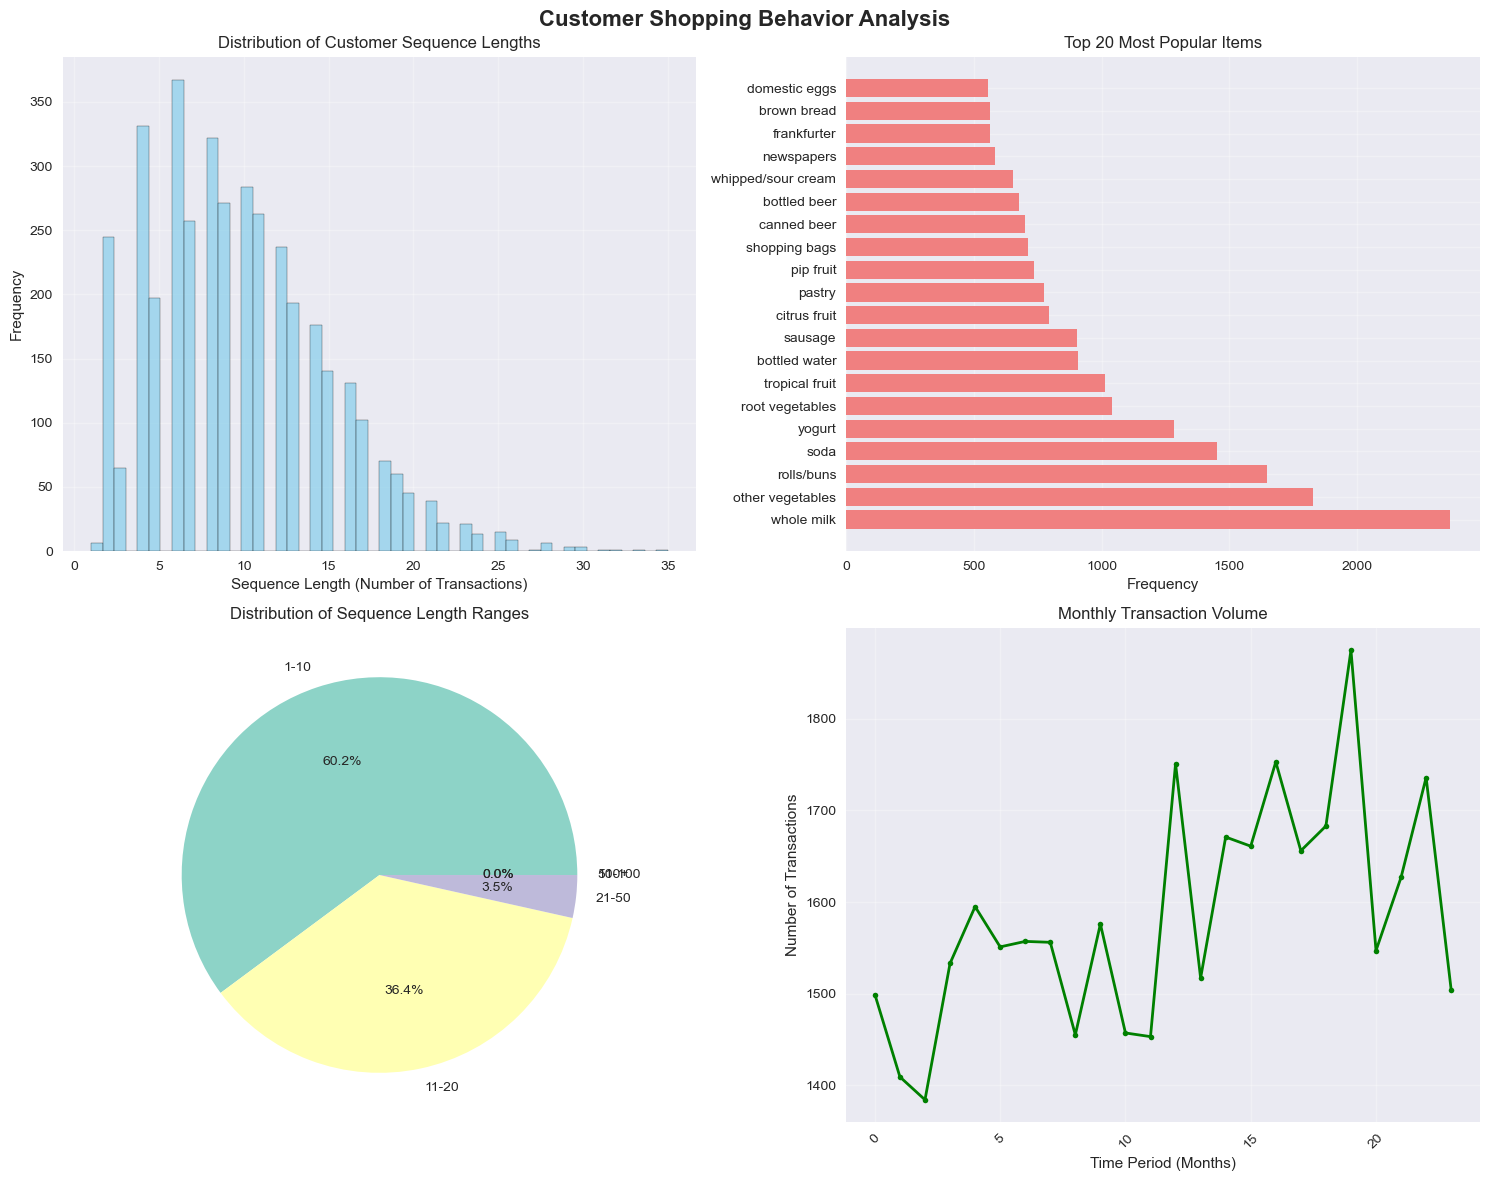

In [28]:
def visualize_customer_behavior(customer_sequences, sequence_lengths):
    """Create comprehensive visualizations of customer behavior"""
    print("\n VISUALIZING CUSTOMER BEHAVIOR")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Customer Shopping Behavior Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Sequence length distribution
    axes[0, 0].hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Sequence Length (Number of Transactions)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Customer Sequence Lengths')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Top 20 most popular items
    all_items = [item for sequence in customer_sequences for item in sequence]
    item_counts = Counter(all_items)
    top_items = item_counts.most_common(20)
    
    items, counts = zip(*top_items)
    axes[0, 1].barh(range(len(items)), counts, color='lightcoral')
    axes[0, 1].set_yticks(range(len(items)))
    axes[0, 1].set_yticklabels(items)
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].set_title('Top 20 Most Popular Items')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Sequence length statistics
    length_ranges = ['1-10', '11-20', '21-50', '51-100', '100+']
    range_counts = [
        len([x for x in sequence_lengths if 1 <= x <= 10]),
        len([x for x in sequence_lengths if 11 <= x <= 20]),
        len([x for x in sequence_lengths if 21 <= x <= 50]),
        len([x for x in sequence_lengths if 51 <= x <= 100]),
        len([x for x in sequence_lengths if x > 100])
    ]
    
    axes[1, 0].pie(range_counts, labels=length_ranges, autopct='%1.1f%%', 
                   colors=sns.color_palette("Set3"))
    axes[1, 0].set_title('Distribution of Sequence Length Ranges')
    
    # Plot 4: Customer activity over time
    monthly_transactions = processed_df.groupby(processed_df['Date'].dt.to_period('M')).size()
    axes[1, 1].plot(range(len(monthly_transactions)), monthly_transactions.values, 
                    marker='o', linewidth=2, markersize=4, color='green')
    axes[1, 1].set_xlabel('Time Period (Months)')
    axes[1, 1].set_ylabel('Number of Transactions')
    axes[1, 1].set_title('Monthly Transaction Volume')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

visualize_customer_behavior(customer_sequences, sequence_lengths)

## Sequential Pattern Mining - PrefixSpan Algorithm

In [30]:

def run_prefixspan_analysis(customer_sequences, min_support=5):
    """Run PrefixSpan algorithm and analyze results"""
    print("\n RUNNING PREFIXSPAN ALGORITHM")
    print("=" * 50)
    
    transactions = customer_sequences.tolist()
    
    print(f"Parameters:")
    print(f"  - Minimum Support: {min_support}")
    print(f"  - Number of Sequences: {len(transactions)}")
    print(f"  - Total Transactions: {sum(len(seq) for seq in transactions)}")
    
    # Run PrefixSpan
    start_time = time.time()
    ps = PrefixSpan(transactions)
    ps_patterns = ps.frequent(min_support)
    end_time = time.time()
    
    # Sort by support
    ps_patterns.sort(key=lambda x: x[0], reverse=True)
    
    print(f"\n PrefixSpan completed in {end_time - start_time:.4f} seconds")
    print(f" Found {len(ps_patterns)} frequent sequential patterns")
    
    return ps_patterns, end_time - start_time

# Run PrefixSpan with different support thresholds
print("Testing different minimum support thresholds...")
support_thresholds = [10, 8, 5, 3]
ps_results = {}

for support in support_thresholds:
    print(f"\n Testing with min_support = {support}")
    patterns, runtime = run_prefixspan_analysis(customer_sequences, support)
    ps_results[support] = {'patterns': patterns[:10], 'runtime': runtime, 'total_patterns': len(patterns)}

Testing different minimum support thresholds...

 Testing with min_support = 10

 RUNNING PREFIXSPAN ALGORITHM
Parameters:
  - Minimum Support: 10
  - Number of Sequences: 3898
  - Total Transactions: 38006

 PrefixSpan completed in 1.8122 seconds
 Found 13847 frequent sequential patterns

 Testing with min_support = 8

 RUNNING PREFIXSPAN ALGORITHM
Parameters:
  - Minimum Support: 8
  - Number of Sequences: 3898
  - Total Transactions: 38006

 PrefixSpan completed in 1.6921 seconds
 Found 20253 frequent sequential patterns

 Testing with min_support = 5

 RUNNING PREFIXSPAN ALGORITHM
Parameters:
  - Minimum Support: 5
  - Number of Sequences: 3898
  - Total Transactions: 38006

 PrefixSpan completed in 2.7669 seconds
 Found 48393 frequent sequential patterns

 Testing with min_support = 3

 RUNNING PREFIXSPAN ALGORITHM
Parameters:
  - Minimum Support: 3
  - Number of Sequences: 3898
  - Total Transactions: 38006

 PrefixSpan completed in 5.1716 seconds
 Found 144798 frequent sequentia

## Display PrefixSpan Results



 PREFIXSPAN RESULTS ANALYSIS

 Top 10 Patterns (min_support = 10):
------------------------------------------------------------
 1. Support: 1786 | Pattern: whole milk
 2. Support: 1468 | Pattern: other vegetables
 3. Support: 1363 | Pattern: rolls/buns
 4. Support: 1222 | Pattern: soda
 5. Support: 1103 | Pattern: yogurt
 6. Support: 911 | Pattern: tropical fruit
 7. Support: 899 | Pattern: root vegetables
 8. Support: 833 | Pattern: bottled water
 9. Support: 803 | Pattern: sausage
10. Support: 723 | Pattern: citrus fruit
Total patterns found: 13847
Execution time: 1.8122 seconds

 Top 10 Patterns (min_support = 8):
------------------------------------------------------------
 1. Support: 1786 | Pattern: whole milk
 2. Support: 1468 | Pattern: other vegetables
 3. Support: 1363 | Pattern: rolls/buns
 4. Support: 1222 | Pattern: soda
 5. Support: 1103 | Pattern: yogurt
 6. Support: 911 | Pattern: tropical fruit
 7. Support: 899 | Pattern: root vegetables
 8. Support: 833 | Pattern: b

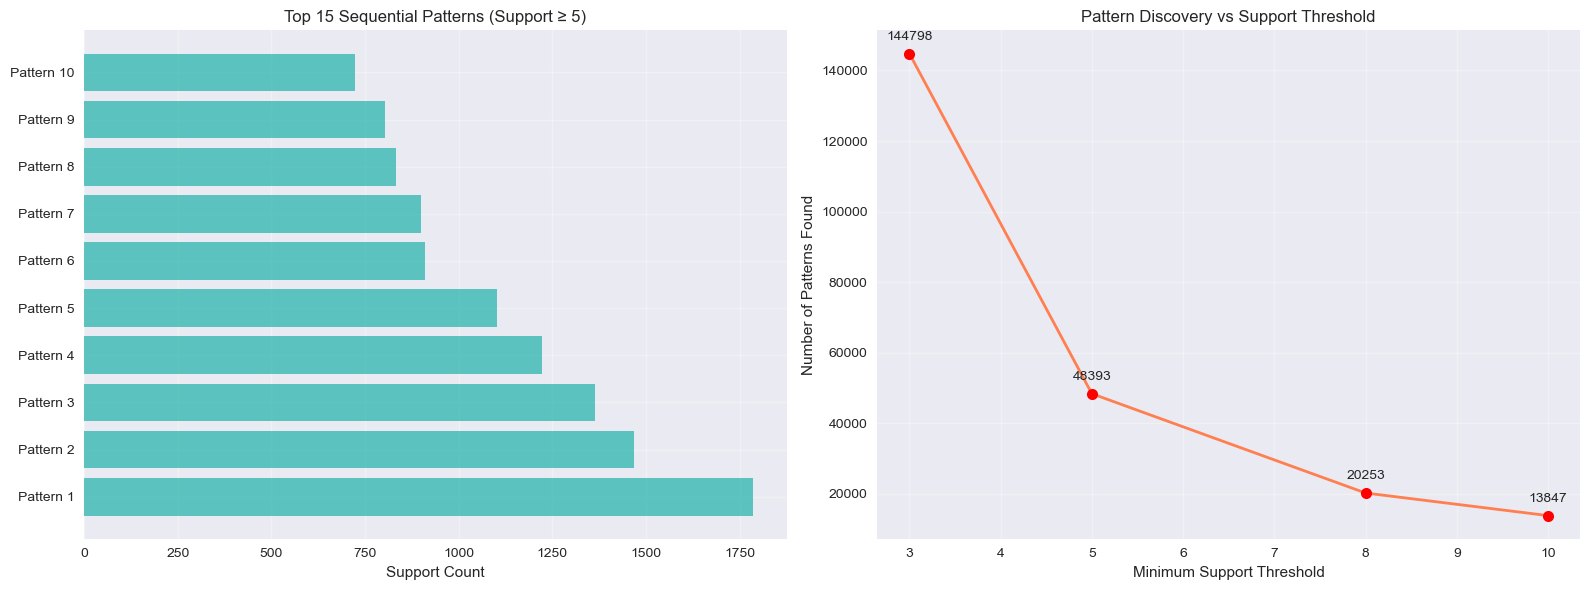

In [31]:
def display_prefixspan_results(ps_results, top_k=10):
    """Display and visualize PrefixSpan results"""
    print("\n PREFIXSPAN RESULTS ANALYSIS")
    print("=" * 50)
    
    # Display patterns for each support threshold
    for support, result in ps_results.items():
        print(f"\n Top {top_k} Patterns (min_support = {support}):")
        print("-" * 60)
        
        if result['patterns']:
            for i, (sup, pattern) in enumerate(result['patterns'][:top_k], 1):
                pattern_str = " → ".join(pattern)
                print(f"{i:2d}. Support: {sup:3d} | Pattern: {pattern_str}")
        else:
            print("No patterns found with this support threshold")
        
        print(f"Total patterns found: {result['total_patterns']}")
        print(f"Execution time: {result['runtime']:.4f} seconds")

# Create visualization for patterns
def visualize_patterns(ps_results, best_support=5):
    """Visualize the frequent patterns"""
    if best_support in ps_results and ps_results[best_support]['patterns']:
        patterns_data = ps_results[best_support]['patterns'][:15]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Pattern support distribution
        supports = [sup for sup, pattern in patterns_data]
        pattern_labels = [f"Pattern {i+1}" for i in range(len(patterns_data))]
        
        ax1.barh(pattern_labels, supports, color='lightseagreen', alpha=0.7)
        ax1.set_xlabel('Support Count')
        ax1.set_title(f'Top 15 Sequential Patterns (Support ≥ {best_support})')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Support threshold vs number of patterns
        supports_list = list(ps_results.keys())
        pattern_counts = [result['total_patterns'] for result in ps_results.values()]
        
        ax2.plot(supports_list, pattern_counts, marker='o', linewidth=2, markersize=8, 
                color='coral', markerfacecolor='red')
        ax2.set_xlabel('Minimum Support Threshold')
        ax2.set_ylabel('Number of Patterns Found')
        ax2.set_title('Pattern Discovery vs Support Threshold')
        ax2.grid(True, alpha=0.3)
        
        for i, count in enumerate(pattern_counts):
            ax2.annotate(f'{count}', (supports_list[i], count), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        plt.tight_layout()
        plt.show()

# Display results
display_prefixspan_results(ps_results)
visualize_patterns(ps_results, best_support=5)

## Pattern Interpretation and Business Insights


In [32]:
def generate_business_insights(ps_results, customer_sequences, best_support=5):
    """Generate meaningful business insights from the patterns"""
    print("\n BUSINESS INSIGHTS AND RECOMMENDATIONS")
    print("=" * 50)
    
    if best_support in ps_results:
        top_patterns = ps_results[best_support]['patterns'][:10]
        
        print(" KEY SHOPPING PATTERNS DISCOVERED:")
        print("-" * 40)
        
        for i, (support, pattern) in enumerate(top_patterns[:5], 1):
            print(f"{i}. { ' → '.join(pattern) }")
            print(f"    This pattern appears in {support} customer sequences")
            
            # Simple insight generation
            if len(pattern) >= 2:
                print(f"    Insight: Customers often buy {pattern[0]} before {pattern[-1]}")
            
            if 'whole milk' in pattern:
                print("    Milk is a frequent item in shopping patterns")
            
            if len(pattern) > 3:
                print("    Multi-item sequential pattern detected")
            
            print()
        
        # Overall statistics
        total_customers = len(customer_sequences)
        print(f"\n OVERALL STATISTICS:")
        print(f"   • Total customers analyzed: {total_customers}")
        print(f"   • Most common pattern support: {top_patterns[0][0]} customers ({top_patterns[0][0]/total_customers*100:.1f}%)")
        
        # Pattern length analysis
        pattern_lengths = [len(pattern) for _, pattern in top_patterns]
        avg_length = np.mean(pattern_lengths)
        print(f"   • Average pattern length: {avg_length:.1f} items")
        
        print(f"\n RECOMMENDATIONS:")
        print("   1. Use these patterns for personalized recommendations")
        print("   2. Design targeted marketing campaigns for sequential purchases")
        print("   3. Optimize store layout based on common item sequences")
        print("   4. Create bundle offers for frequently co-purchased items")

generate_business_insights(ps_results, customer_sequences)


 BUSINESS INSIGHTS AND RECOMMENDATIONS
 KEY SHOPPING PATTERNS DISCOVERED:
----------------------------------------
1. whole milk
    This pattern appears in 1786 customer sequences
    Milk is a frequent item in shopping patterns

2. other vegetables
    This pattern appears in 1468 customer sequences

3. rolls/buns
    This pattern appears in 1363 customer sequences

4. soda
    This pattern appears in 1222 customer sequences

5. yogurt
    This pattern appears in 1103 customer sequences


 OVERALL STATISTICS:
   • Total customers analyzed: 3898
   • Most common pattern support: 1786 customers (45.8%)
   • Average pattern length: 1.0 items

 RECOMMENDATIONS:
   1. Use these patterns for personalized recommendations
   2. Design targeted marketing campaigns for sequential purchases
   3. Optimize store layout based on common item sequences
   4. Create bundle offers for frequently co-purchased items


## Cell 8: Save Results and Summary

In [33]:

def save_results(customer_sequences, ps_results):
    """Save the processed data and results for future use"""
    print("\n SAVING RESULTS")
    print("=" * 50)
    
    # Save transactions
    transactions = customer_sequences.tolist()
    with open("../data/transactions.pkl", "wb") as f:
        pickle.dump(transactions, f)
    
    # Save patterns
    results_summary = {
        'customer_sequences': customer_sequences,
        'prefixspan_results': ps_results,
        'total_customers': len(customer_sequences),
        'total_transactions': sum(len(seq) for seq in transactions),
        'timestamp': time.time()
    }
    
    with open("../data/pattern_mining_results.pkl", "wb") as f:
        pickle.dump(results_summary, f)
    
    # Create a summary DataFrame
    summary_data = []
    for support, result in ps_results.items():
        if result['patterns']:
            top_pattern_support = result['patterns'][0][0] if result['patterns'] else 0
            top_pattern = " → ".join(result['patterns'][0][1]) if result['patterns'] else "None"
        else:
            top_pattern_support = 0
            top_pattern = "None"
            
        summary_data.append({
            'min_support': support,
            'total_patterns': result['total_patterns'],
            'top_pattern_support': top_pattern_support,
            'top_pattern': top_pattern,
            'runtime_seconds': f"{result['runtime']:.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("Results Summary:")
    display(summary_df)
    
    print(f"✅ Prepared {len(transactions)} customer sequences")
    print(f"✅ Saved transactions to '../data/transactions.pkl'")
    print(f"✅ Saved complete results to '../data/pattern_mining_results.pkl'")
    print(f"✅ Analysis completed successfully!")

save_results(customer_sequences, ps_results)


 SAVING RESULTS
Results Summary:


,min_support,total_patterns,top_pattern_support,top_pattern,runtime_seconds
0,10,13847,1786,whole milk,1.8122
1,8,20253,1786,whole milk,1.6921
2,5,48393,1786,whole milk,2.7669
3,3,144798,1786,whole milk,5.1716


✅ Prepared 3898 customer sequences
✅ Saved transactions to '../data/transactions.pkl'
✅ Saved complete results to '../data/pattern_mining_results.pkl'
✅ Analysis completed successfully!
